In this example, we create a sinogram using a Shepp-Logan phantom and use self-supervised CNNs to reconstruct the tomographic image. The following CNNs can be tested: Automap, GANrec and SD2I with/without upsampling layers.

In [1]:
from nDTomo.sim.shapes.phantoms import SheppLogan
from nDTomo.utils.misc import showim
from nDTomo.ct.conv_tomo import fbpvol, sinocentering

from nDTomo.nn.models_tf import GANrec, SD2I, Automap, Discriminator
from nDTomo.nn.utils_tf import tf_gpu_devices, ReduceLROnPlateau_custom
from nDTomo.nn.tomo_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_mask_circle
from nDTomo.nn.losses_tf import ssim_mae_loss, discriminator_loss
from nDTomo.utils.misc import cirmask

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

Check if Tensorflow will run on GPU

In [2]:
tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 

print(physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Let's create the image, sinogram, and mask.

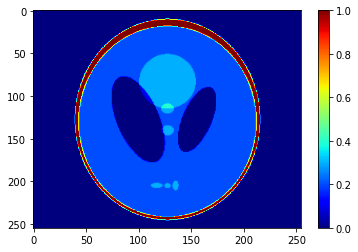

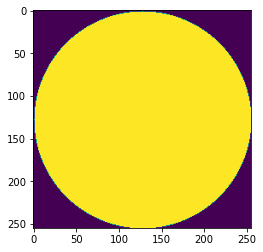

In [3]:
npix = 256# image size
npr = 256 # number of projections
ang_samp = 4 # angular undersampling factor

npr = npr // ang_samp

with_disc = True # Use discriminator or not

method = 'SD2Iup' # Choose method from 'SD2Iup', 'SD2I', 'GANrec', 'Automap'

factor = 8 # Used for SD2I methods

nim = 1

im = SheppLogan(npix)

# forward to create a comparable result, npix should be odd. one line/coloum of empty array are removed from edge 
odd_correction = False
if npix % 2 == 0:
    pad = np.zeros_like(im)
    im = im[:-1,:-1]
    npix -= 1
    odd_correction = True

showim(im, 1, cmap = 'jet')

mask = np.ones((npix, npix))
mask = cirmask(mask,0)

mask = np.repeat(mask[:, :, np.newaxis], 1, axis=2)
plt.imshow(mask[:,:,0])

Let's create the sinogram

(1, 255, 255, 1)


c:\programdata\anaconda3\lib\site-packages\tensorflow_addons\image\transform_ops.py:142: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  warnings.warn(


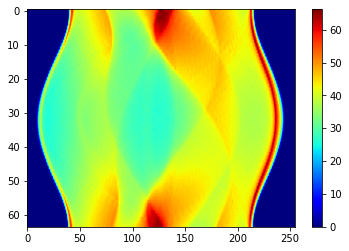

(1, 64, 255)


In [4]:
data = im.reshape([npix,npix,1])

theta = tf_create_angles(npr)

imtf = tf_tomo_transf(im)
print(imtf.shape)

pattern_input = tf_tomo_radon(imtf, theta, interp_method='bilinear')
showim(tf_tomo_squeeze(pattern_input), 2)
pattern_input = pattern_input[:,:,:,0]

print(pattern_input.shape)

Calculate the reconstructed image using the filtered back projection algorithm

The dimensions of the reconstructed volume are  (255, 255)


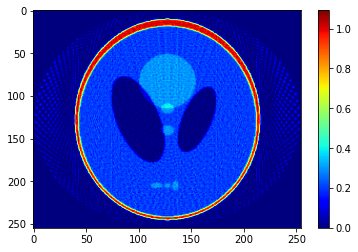

In [5]:
fbp = fbpvol(np.array(pattern_input[0]).transpose(), theta=np.rad2deg(theta), nt = npix)
showim(fbp, 3, clim=(0, np.max(fbp)))

Next we prepare the function for training the neural network

Training loop

In [6]:
if not with_disc:
    @tf.function 
    def train_step(input_number, dataset):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
            generated_img = tf.math.abs(generated_img)

            print(generated_img.shape)

            pattern_gen = tf_tomo_radon(generated_img, theta)
            pattern_gen = pattern_gen[:,:,:,0]
            pattern_gen = tf.transpose(pattern_gen, [1, 2, 0])
            dataset = tf.transpose(dataset, [1, 2, 0])
            print(3)
            print(pattern_gen.shape)
            print(dataset.shape)

            matrix_loss = ssim_mae_loss(dataset, pattern_gen)

        grad_gen = tape.gradient(matrix_loss, generator.trainable_variables)

        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        return matrix_loss

else:
    @tf.function 
    def train_step(input_number, dataset):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
            generated_img = tf.math.abs(generated_img)
            print(generated_img.shape)

            pattern_gen = tf_tomo_radon(generated_img, theta)
            
            real_output = discriminator(tf.expand_dims(dataset, -1))
            generated_output = discriminator(pattern_gen)
            
            pattern_gen = pattern_gen[:,:,:,0]
            pattern_gen = tf.transpose(pattern_gen, [1, 2, 0])
            dataset = tf.transpose(dataset, [1, 2, 0])
            print(2)
            print(dataset.shape)
            print(pattern_gen.shape)
            gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output,
                                      labels=tf.ones_like(generated_output))) \
                       + ssim_mae_loss(dataset, pattern_gen)

            disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output, labels=tf.ones_like(real_output)))
            disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output, labels=tf.zeros_like(generated_output)))
            disc_loss = disc_loss_real+disc_loss_fake

        grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)
        grad_gen = tape.gradient(gen_loss, generator.trainable_variables)

        disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))
        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        print(3)
        return gen_loss

Setup the model, optimizers and learning rate

In [7]:
if method == 'SD2Iup':
    generator = SD2I(npix, factor)
elif method == 'SD2I':
    generator = SD2I(npix, factor, upsample=False)
elif method == 'GANrec':
    generator = GANrec(npix)
elif method == 'Automap':
    generator = Automap(npix, npr)
    
if with_disc:
    discriminator = Discriminator(npix, npr)
    disc_optimizer = tf.keras.optimizers.Adam(0.0005)
    
generator.summary()
gen_optimizer = tf.keras.optimizers.Adam(0.0005)

reduce_rl_plateau = ReduceLROnPlateau_custom(patience=int(300/100),
                            factor=0.5,
                            verbose=1, 
                            optim_lr=gen_optimizer.learning_rate, 
                            reduce_lin=True)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             2129920   
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 8)        

Setup the epochs needed and start the training loop.

In [8]:
epochs = 8000
save_interval = 100

chemct_tf = tf.cast(pattern_input, 'float32')

if method == 'GANrec':
    bp = tf_tomo_bp(chemct_tf, theta)
    input_number = bp
elif method == 'Automap':
    input_number = chemct_tf
else:
    input_number = tf.cast(np.array([1]), 'float32')

start = time.time()
reduce_rl_plateau.on_train_begin()
kk = 1

for epoch in tqdm(range(epochs)):

    loss = train_step(input_number, chemct_tf)

    if epoch % save_interval == 0 and epoch != 0:

        print('Time for epoch {} to {} is {} sec/it - gen_loss = {}'.format(epoch - save_interval + 1, epoch, (time.time() - start) / save_interval, loss))
        start = time.time()
        plt.close()

        reduce_rl_plateau.on_epoch_end(kk, loss)
        kk += 1


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

1
(1, 255, 255, 1)


c:\programdata\anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:493: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  return py_builtins.overload_of(f)(*args)


2
(64, 255, 1)
(64, 255, 1)
3
1
(1, 255, 255, 1)
2
(64, 255, 1)
(64, 255, 1)
3


  1%|█                                                                              | 105/8000 [00:10<04:12, 31.31it/s]

Time for epoch 1 to 100 is 0.09983295440673828 sec/it - gen_loss = 1.2195974588394165


  3%|██                                                                             | 205/8000 [00:13<04:07, 31.46it/s]

Time for epoch 101 to 200 is 0.03165534734725952 sec/it - gen_loss = 1.0908461809158325


  4%|███                                                                            | 305/8000 [00:16<04:05, 31.35it/s]

Time for epoch 201 to 300 is 0.03169718742370606 sec/it - gen_loss = 0.97709721326828


  5%|███▉                                                                           | 405/8000 [00:19<04:00, 31.55it/s]

Time for epoch 301 to 400 is 0.031605467796325684 sec/it - gen_loss = 0.8867199420928955


  6%|████▉                                                                          | 505/8000 [00:22<04:00, 31.19it/s]

Time for epoch 401 to 500 is 0.03176693677902222 sec/it - gen_loss = 0.8841089010238647


  8%|█████▉                                                                         | 605/8000 [00:25<03:56, 31.32it/s]

Time for epoch 501 to 600 is 0.03176660537719726 sec/it - gen_loss = 0.9173353314399719


  9%|██████▉                                                                        | 705/8000 [00:29<03:53, 31.27it/s]

Time for epoch 601 to 700 is 0.031815974712371825 sec/it - gen_loss = 0.9181593656539917


 10%|███████▉                                                                       | 805/8000 [00:32<03:50, 31.23it/s]

Time for epoch 701 to 800 is 0.03194458723068237 sec/it - gen_loss = 0.8482243418693542


 11%|████████▉                                                                      | 905/8000 [00:35<03:49, 30.97it/s]

Time for epoch 801 to 900 is 0.03197448015213013 sec/it - gen_loss = 0.8529291152954102


 13%|█████████▊                                                                    | 1005/8000 [00:38<03:44, 31.09it/s]

Time for epoch 901 to 1000 is 0.03203597068786621 sec/it - gen_loss = 0.8802230954170227


 14%|██████████▊                                                                   | 1105/8000 [00:41<03:42, 30.98it/s]

Time for epoch 1001 to 1100 is 0.03208639860153198 sec/it - gen_loss = 0.820551335811615


 15%|███████████▋                                                                  | 1205/8000 [00:45<03:40, 30.81it/s]

Time for epoch 1101 to 1200 is 0.03225623369216919 sec/it - gen_loss = 0.8803243637084961


 16%|████████████▋                                                                 | 1305/8000 [00:48<03:37, 30.85it/s]

Time for epoch 1201 to 1300 is 0.032223823070526125 sec/it - gen_loss = 0.958318829536438


 18%|█████████████▋                                                                | 1405/8000 [00:51<03:35, 30.63it/s]

Time for epoch 1301 to 1400 is 0.03247313499450684 sec/it - gen_loss = 0.9028505086898804

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


 19%|██████████████▋                                                               | 1505/8000 [00:54<03:32, 30.59it/s]

Time for epoch 1401 to 1500 is 0.032504181861877444 sec/it - gen_loss = 0.8437317609786987


 20%|███████████████▋                                                              | 1605/8000 [00:58<03:28, 30.67it/s]

Time for epoch 1501 to 1600 is 0.03255295276641846 sec/it - gen_loss = 0.8110442161560059


 21%|████████████████▌                                                             | 1705/8000 [01:01<03:27, 30.40it/s]

Time for epoch 1601 to 1700 is 0.03260282516479492 sec/it - gen_loss = 0.807037889957428


 23%|█████████████████▌                                                            | 1805/8000 [01:04<03:23, 30.47it/s]

Time for epoch 1701 to 1800 is 0.03266458511352539 sec/it - gen_loss = 0.8726183176040649


 24%|██████████████████▌                                                           | 1905/8000 [01:08<03:20, 30.38it/s]

Time for epoch 1801 to 1900 is 0.032733747959136965 sec/it - gen_loss = 0.8139509558677673


 25%|███████████████████▌                                                          | 2005/8000 [01:11<03:18, 30.23it/s]

Time for epoch 1901 to 2000 is 0.03279229164123535 sec/it - gen_loss = 0.8381652235984802

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


 26%|████████████████████▌                                                         | 2105/8000 [01:14<03:14, 30.31it/s]

Time for epoch 2001 to 2100 is 0.032843732833862306 sec/it - gen_loss = 0.8138562440872192


 28%|█████████████████████▍                                                        | 2205/8000 [01:17<03:11, 30.23it/s]

Time for epoch 2101 to 2200 is 0.03294187068939209 sec/it - gen_loss = 0.7825965881347656


 29%|██████████████████████▍                                                       | 2305/8000 [01:21<03:08, 30.20it/s]

Time for epoch 2201 to 2300 is 0.03291198492050171 sec/it - gen_loss = 0.785161018371582


 30%|███████████████████████▍                                                      | 2405/8000 [01:24<03:04, 30.33it/s]

Time for epoch 2301 to 2400 is 0.032951884269714356 sec/it - gen_loss = 0.7901204824447632


 31%|████████████████████████▍                                                     | 2505/8000 [01:27<03:00, 30.51it/s]

Time for epoch 2401 to 2500 is 0.03277231693267822 sec/it - gen_loss = 0.7785229682922363


 33%|█████████████████████████▍                                                    | 2605/8000 [01:31<02:57, 30.36it/s]

Time for epoch 2501 to 2600 is 0.032772336006164554 sec/it - gen_loss = 0.7645403146743774


 34%|██████████████████████████▎                                                   | 2705/8000 [01:34<02:54, 30.35it/s]

Time for epoch 2601 to 2700 is 0.03291198492050171 sec/it - gen_loss = 0.7592090964317322


 35%|███████████████████████████▎                                                  | 2804/8000 [01:37<02:52, 30.11it/s]

Time for epoch 2701 to 2800 is 0.0331114411354065 sec/it - gen_loss = 0.7939320206642151


 36%|████████████████████████████▎                                                 | 2904/8000 [01:40<02:49, 30.10it/s]

Time for epoch 2801 to 2900 is 0.03299175262451172 sec/it - gen_loss = 0.7827102541923523


 38%|█████████████████████████████▎                                                | 3004/8000 [01:44<02:46, 30.05it/s]

Time for epoch 2901 to 3000 is 0.032998690605163576 sec/it - gen_loss = 0.7415978908538818


 39%|██████████████████████████████▎                                               | 3104/8000 [01:47<02:42, 30.11it/s]

Time for epoch 3001 to 3100 is 0.033013174533843996 sec/it - gen_loss = 0.7839205861091614


 40%|███████████████████████████████▏                                              | 3204/8000 [01:50<02:39, 30.06it/s]

Time for epoch 3101 to 3200 is 0.03304161787033081 sec/it - gen_loss = 0.7690378427505493


 41%|████████████████████████████████▏                                             | 3304/8000 [01:54<02:34, 30.32it/s]

Time for epoch 3201 to 3300 is 0.032882082462310794 sec/it - gen_loss = 0.7744399905204773

Epoch 00034: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


 43%|█████████████████████████████████▏                                            | 3404/8000 [01:57<02:32, 30.05it/s]

Time for epoch 3301 to 3400 is 0.03297183275222779 sec/it - gen_loss = 0.7995572090148926


 44%|██████████████████████████████████▏                                           | 3504/8000 [02:00<02:29, 29.99it/s]

Time for epoch 3401 to 3500 is 0.0330815315246582 sec/it - gen_loss = 0.7537907958030701


 45%|███████████████████████████████████▏                                          | 3604/8000 [02:04<02:26, 30.10it/s]

Time for epoch 3501 to 3600 is 0.033071601390838624 sec/it - gen_loss = 0.7377578020095825


 46%|████████████████████████████████████                                          | 3704/8000 [02:07<02:23, 30.02it/s]

Time for epoch 3601 to 3700 is 0.03310148954391479 sec/it - gen_loss = 0.7387521862983704


 48%|█████████████████████████████████████                                         | 3804/8000 [02:10<02:19, 29.98it/s]

Time for epoch 3701 to 3800 is 0.03310148954391479 sec/it - gen_loss = 0.6369317173957825


 49%|██████████████████████████████████████                                        | 3904/8000 [02:13<02:16, 29.99it/s]

Time for epoch 3801 to 3900 is 0.033181257247924804 sec/it - gen_loss = 0.7289803624153137


 50%|███████████████████████████████████████                                       | 4006/8000 [02:17<02:13, 30.03it/s]

Time for epoch 3901 to 4000 is 0.03319386720657349 sec/it - gen_loss = 0.7154466509819031


 51%|████████████████████████████████████████                                      | 4105/8000 [02:20<02:10, 29.93it/s]

Time for epoch 4001 to 4100 is 0.03319124221801758 sec/it - gen_loss = 0.7517638802528381

Epoch 00042: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


 53%|████████████████████████████████████████▉                                     | 4204/8000 [02:23<02:06, 29.96it/s]

Time for epoch 4101 to 4200 is 0.03324224948883057 sec/it - gen_loss = 0.7659693360328674


 54%|█████████████████████████████████████████▉                                    | 4305/8000 [02:27<02:03, 29.92it/s]

Time for epoch 4201 to 4300 is 0.03317122936248779 sec/it - gen_loss = 0.743448793888092


 55%|██████████████████████████████████████████▉                                   | 4405/8000 [02:30<02:00, 29.95it/s]

Time for epoch 4301 to 4400 is 0.03321119546890259 sec/it - gen_loss = 0.7099496126174927

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


 56%|███████████████████████████████████████████▉                                  | 4504/8000 [02:33<01:56, 29.93it/s]

Time for epoch 4401 to 4500 is 0.0332111668586731 sec/it - gen_loss = 0.702094316482544


 58%|████████████████████████████████████████████▉                                 | 4604/8000 [02:37<01:53, 30.00it/s]

Time for epoch 4501 to 4600 is 0.0331413722038269 sec/it - gen_loss = 0.6992446780204773


 59%|█████████████████████████████████████████████▊                                | 4705/8000 [02:40<01:49, 30.00it/s]

Time for epoch 4601 to 4700 is 0.0332510781288147 sec/it - gen_loss = 0.6249509453773499


 60%|██████████████████████████████████████████████▊                               | 4804/8000 [02:43<01:46, 29.93it/s]

Time for epoch 4701 to 4800 is 0.033251070976257326 sec/it - gen_loss = 0.7289751768112183


 61%|███████████████████████████████████████████████▊                              | 4904/8000 [02:47<01:43, 29.95it/s]

Time for epoch 4801 to 4900 is 0.03322117328643799 sec/it - gen_loss = 0.6992416381835938


 63%|████████████████████████████████████████████████▊                             | 5006/8000 [02:50<01:40, 29.68it/s]

Time for epoch 4901 to 5000 is 0.03324110984802246 sec/it - gen_loss = 0.7009847164154053

Epoch 00051: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


 64%|█████████████████████████████████████████████████▊                            | 5105/8000 [02:53<01:36, 29.93it/s]

Time for epoch 5001 to 5100 is 0.03320119857788086 sec/it - gen_loss = 0.6976770162582397


 65%|██████████████████████████████████████████████████▋                           | 5204/8000 [02:57<01:33, 29.77it/s]

Time for epoch 5101 to 5200 is 0.033290953636169435 sec/it - gen_loss = 0.6733673810958862


 66%|███████████████████████████████████████████████████▋                          | 5307/8000 [03:00<01:29, 30.03it/s]

Time for epoch 5201 to 5300 is 0.033261041641235355 sec/it - gen_loss = 0.707454264163971

Epoch 00054: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


 68%|████████████████████████████████████████████████████▋                         | 5406/8000 [03:03<01:25, 30.23it/s]

Time for epoch 5301 to 5400 is 0.03307154893875122 sec/it - gen_loss = 0.702942430973053


 69%|█████████████████████████████████████████████████████▋                        | 5505/8000 [03:07<01:22, 30.07it/s]

Time for epoch 5401 to 5500 is 0.03307152986526489 sec/it - gen_loss = 0.6958268880844116


 70%|██████████████████████████████████████████████████████▋                       | 5605/8000 [03:10<01:19, 30.03it/s]

Time for epoch 5501 to 5600 is 0.033181257247924804 sec/it - gen_loss = 0.7008240222930908

Epoch 00057: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.


 71%|███████████████████████████████████████████████████████▋                      | 5707/8000 [03:13<01:16, 29.93it/s]

Time for epoch 5601 to 5700 is 0.03327101707458496 sec/it - gen_loss = 0.6977952718734741


 73%|████████████████████████████████████████████████████████▌                     | 5804/8000 [03:17<01:13, 29.80it/s]

Time for epoch 5701 to 5800 is 0.03327325344085694 sec/it - gen_loss = 0.6928284764289856


 74%|█████████████████████████████████████████████████████████▌                    | 5906/8000 [03:20<01:10, 29.90it/s]

Time for epoch 5801 to 5900 is 0.03327101469039917 sec/it - gen_loss = 0.7092759013175964

Epoch 00060: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.


 75%|██████████████████████████████████████████████████████████▌                   | 6005/8000 [03:23<01:06, 29.91it/s]

Time for epoch 5901 to 6000 is 0.033221158981323246 sec/it - gen_loss = 0.6982647776603699


 76%|███████████████████████████████████████████████████████████▌                  | 6106/8000 [03:27<01:03, 29.86it/s]

Time for epoch 6001 to 6100 is 0.03330093383789062 sec/it - gen_loss = 0.6929032206535339


 78%|████████████████████████████████████████████████████████████▌                 | 6206/8000 [03:30<00:59, 29.96it/s]

Time for epoch 6101 to 6200 is 0.033320882320404054 sec/it - gen_loss = 0.7022417187690735

Epoch 00063: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.


 79%|█████████████████████████████████████████████████████████████▍                | 6305/8000 [03:33<00:55, 30.35it/s]

Time for epoch 6201 to 6300 is 0.03320117473602295 sec/it - gen_loss = 0.6955587863922119


 80%|██████████████████████████████████████████████████████████████▍               | 6404/8000 [03:37<00:52, 30.18it/s]

Time for epoch 6301 to 6400 is 0.0331114411354065 sec/it - gen_loss = 0.6972205638885498


 81%|███████████████████████████████████████████████████████████████▍              | 6507/8000 [03:40<00:49, 29.86it/s]

Time for epoch 6401 to 6500 is 0.03313140869140625 sec/it - gen_loss = 0.6972706913948059

Epoch 00066: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.


 83%|████████████████████████████████████████████████████████████████▍             | 6605/8000 [03:43<00:46, 29.86it/s]

Time for epoch 6501 to 6600 is 0.03335079193115234 sec/it - gen_loss = 0.6974740028381348


 84%|█████████████████████████████████████████████████████████████████▍            | 6706/8000 [03:47<00:43, 29.95it/s]

Time for epoch 6601 to 6700 is 0.03330092906951904 sec/it - gen_loss = 0.6983346343040466


 85%|██████████████████████████████████████████████████████████████████▎           | 6805/8000 [03:50<00:39, 30.13it/s]

Time for epoch 6701 to 6800 is 0.0331014609336853 sec/it - gen_loss = 0.6981385946273804

Epoch 00069: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.


 86%|███████████████████████████████████████████████████████████████████▎          | 6905/8000 [03:53<00:36, 30.33it/s]

Time for epoch 6801 to 6900 is 0.03279230117797852 sec/it - gen_loss = 0.6981679201126099


 88%|████████████████████████████████████████████████████████████████████▎         | 7005/8000 [03:57<00:33, 29.98it/s]

Time for epoch 6901 to 7000 is 0.03303165197372437 sec/it - gen_loss = 0.6980591416358948


 89%|█████████████████████████████████████████████████████████████████████▎        | 7104/8000 [04:00<00:29, 29.96it/s]

Time for epoch 7001 to 7100 is 0.03319124221801758 sec/it - gen_loss = 0.6982733607292175

Epoch 00072: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.


 90%|██████████████████████████████████████████████████████████████████████▏       | 7204/8000 [04:03<00:26, 30.03it/s]

Time for epoch 7101 to 7200 is 0.03319120407104492 sec/it - gen_loss = 0.6968429684638977


 91%|███████████████████████████████████████████████████████████████████████▏      | 7304/8000 [04:06<00:23, 29.94it/s]

Time for epoch 7201 to 7300 is 0.03318133354187012 sec/it - gen_loss = 0.6785358786582947


 93%|████████████████████████████████████████████████████████████████████████▏     | 7404/8000 [04:10<00:19, 29.97it/s]

Time for epoch 7301 to 7400 is 0.03326103687286377 sec/it - gen_loss = 0.6979117393493652

Epoch 00075: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7506/8000 [04:13<00:16, 29.99it/s]

Time for epoch 7401 to 7500 is 0.03325106620788574 sec/it - gen_loss = 0.6974605917930603


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7605/8000 [04:16<00:13, 29.94it/s]

Time for epoch 7501 to 7600 is 0.033211159706115725 sec/it - gen_loss = 0.6978307962417603


 96%|███████████████████████████████████████████████████████████████████████████   | 7705/8000 [04:20<00:09, 29.92it/s]

Time for epoch 7601 to 7700 is 0.03318125486373901 sec/it - gen_loss = 0.6972249746322632

Epoch 00078: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.


 98%|████████████████████████████████████████████████████████████████████████████  | 7805/8000 [04:23<00:06, 30.27it/s]

Time for epoch 7701 to 7800 is 0.03289201498031616 sec/it - gen_loss = 0.700305163860321


 99%|█████████████████████████████████████████████████████████████████████████████ | 7905/8000 [04:26<00:03, 30.51it/s]

Time for epoch 7801 to 7900 is 0.03284214973449707 sec/it - gen_loss = 0.6984329223632812


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [04:29<00:00, 29.63it/s]


Finally we plot the reconstructed image and compare it the filter back projected

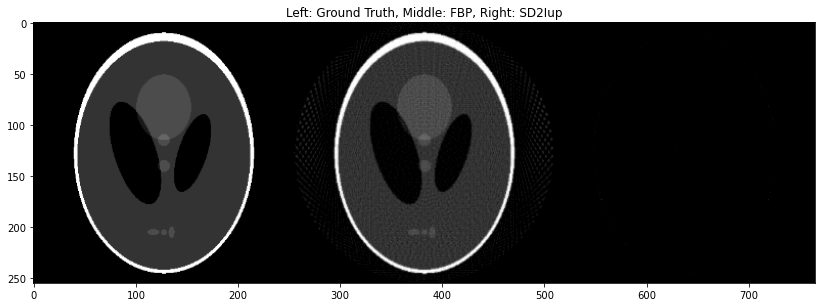

In [9]:
generated_img = generator(input_number)
generated_img = np.array(generated_img)
generated_img[generated_img<0] = 0
generated_img = generated_img[0,:,:,0] * mask[:,:,0]

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((im, fbp, generated_img[:,:]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: {}'.format(method))
plt.show()

In [10]:
mask.shape

(255, 255, 1)

Do SIRT, SART, CGLS

In [11]:
img = [generated_img,  fbp, im]
text = [str(method), 'FBP with angular_undersampling', 'ground truth']
# %%

import matplotlib.pyplot as plt
import time
from skimage.draw import random_shapes
import astra
from numpy import deg2rad, arange
#%%
def astra_rec_single(sino, theta=None, scanrange = '180', method='FBP_CUDA', filt='Ram-Lak', nits = None):
    
    '''
    2D ct reconstruction using the astra-toolbox
    1st dim in sinogram is translation steps, 2nd is projections
    Available astra-toolbox reconstruction algorithms:
    ART, SART, SIRT, CGLS, FBP
    SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA
    
    possible values for FilterType:
    none, ram-lak, shepp-logan, cosine, hamming, hann, tukey, lanczos,
    triangular, gaussian, barlett-hann, blackman, nuttall, blackman-harris,
    blackman-nuttall, flat-top, kaiser, parzen    
    '''
    
    npr = sino.shape[1] # Number of projections
    
    if theta is None:
        if scanrange == '180':
            theta = deg2rad(arange(0, 180, 180/npr))
        elif scanrange == '360':
            theta = deg2rad(arange(0, 360, 360/npr))
            
    # Create a basic square volume geometry
    vol_geom = astra.create_vol_geom(sino.shape[0], sino.shape[0])
    # Create a parallel beam geometry with 180 angles between 0 and pi, and image.shape[0] detector pixels of width 1.
    proj_geom = astra.create_proj_geom('parallel', 1.0, int(1.0*sino.shape[0]), theta)
    # Create a sinogram using the GPU.
    proj_id = astra.create_projector('strip',proj_geom,vol_geom)
    sinogram_id = astra.data2d.create('-sino', proj_geom, sino.transpose())
    
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
    
    cfg = astra.astra_dict(method)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id
    if method == 'FBP' or method == 'FBP_CUDA':
        cfg['option'] = { 'FilterType': filt }
    else:
        if method == 'SART' or method == 'SIRT' or method == 'SART_CUDA' or method == 'SIRT_CUDA' or method == 'ART' or method == 'CGLS':
            cfg['option']={}
            cfg['option']['MinConstraint'] = 0
        if nits is None:
            nits = 10 
    
    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    start=time.time()

    if method == 'FBP' or method == 'FBP_CUDA':
        rec = astra.algorithm.run(alg_id)
    else:
        rec = astra.algorithm.run(alg_id, nits)
    
    # Get the result
    
    rec = astra.data2d.get(rec_id)
    
    print((time.time()-start))
        
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(proj_id)
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    
    return(rec)
# %%
# %%

method = ['SART_CUDA', 'CGLS_CUDA', 'SIRT_CUDA']

for i in method:
    rec = astra_rec_single(np.array(pattern_input[0,:,:]).transpose(), theta=None, scanrange = '180', method=i, filt='Ram-Lak', nits = 250)
    rec[rec<0] = 0
    img.append(rec)
    text.append(i)

0.16954565048217773
0.2772562503814697
0.22439932823181152


In [12]:
pattern_input.shape

TensorShape([1, 64, 255])

Finally calculate some metrics to compare the reconstructed images

In [13]:
if odd_correction:
    full = np.zeros([npix+1, npix+1])
    full[:-1,:-1] = im
    full = tf.cast(full, tf.float32)
else:
    full = tf.cast(im, tf.float32)
maxpoint = np.max(full)


In [14]:
print(full.shape)
j = 0
for i in img:
    print(i.shape)
    text_sub = text[j]
    j += 1
    im = np.reshape(i, (1, npix, npix,1))
    gt = np.reshape(full, (1, full.shape[0],  full.shape[1],1))
    
    gt = tf.cast(gt, tf.float32)
    if odd_correction:
        im_new = np.zeros([1, npix+1, npix+1, 1])
        im_new[:, :-1,:-1, :] = im
        im = im_new
        
        i_new = np.zeros([npix+1, npix+1])
        i_new[:-1,:-1] = i
        i = i_new
    
    i = tf.cast(i, tf.float32)
    im = tf.cast(im, tf.float32)
    mae = tf.reduce_mean(tf.keras.losses.MAE(i, full)).numpy()

    mse = tf.reduce_mean(tf.keras.losses.MSE(i, full)).numpy()

    psnr = tf.image.psnr(im, gt, maxpoint).numpy()

    ssim = tf.image.ssim(im, gt, maxpoint).numpy()
    print(text_sub)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('SSIM: ', ssim)
    print('PSNR: ', psnr)
    print('--------------------------------------')

(256, 256)
(255, 255)
SD2Iup
MAE:  0.12313913
MSE:  0.05879149
SSIM:  [0.47623956]
PSNR:  [12.306854]
--------------------------------------
(255, 255)
FBP with angular_undersampling
MAE:  0.02491975
MSE:  0.0018220679
SSIM:  [0.6585386]
PSNR:  [27.394352]
--------------------------------------
(255, 255)
ground truth
MAE:  0.0
MSE:  0.0
SSIM:  [1.]
PSNR:  [inf]
--------------------------------------
(255, 255)
SART_CUDA
MAE:  0.009741093
MSE:  0.00086676155
SSIM:  [0.93994474]
PSNR:  [30.621002]
--------------------------------------
(255, 255)
CGLS_CUDA
MAE:  0.021071542
MSE:  0.0019140677
SSIM:  [0.5998395]
PSNR:  [27.180426]
--------------------------------------
(255, 255)
SIRT_CUDA
MAE:  0.010228127
MSE:  0.0010317385
SSIM:  [0.93579036]
PSNR:  [29.864304]
--------------------------------------


Now plot the result out

0
1
2
3
4
5


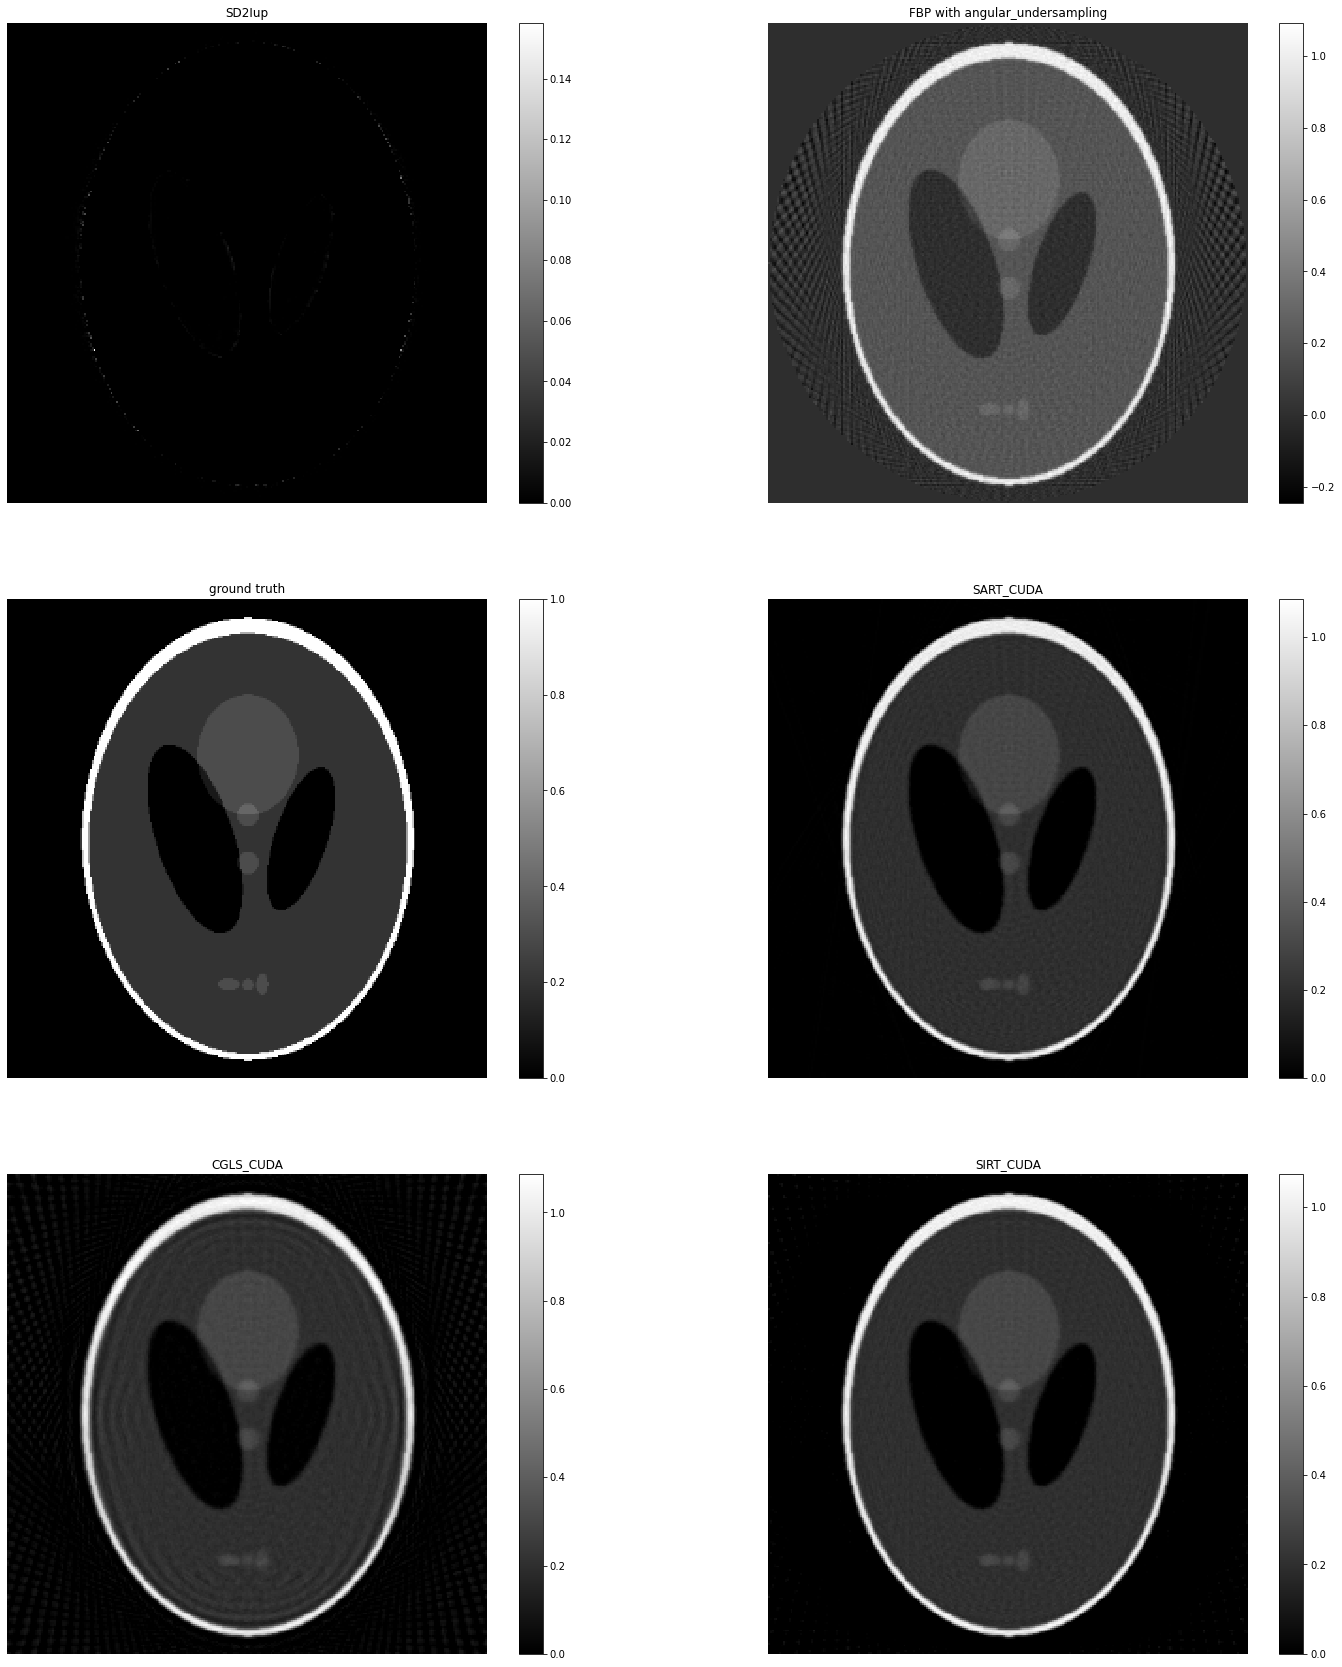

In [15]:
def plotfigs_imgs(imagelist, legendlist, rows=1, cols=5, figsize=(20,3), cl=True, cmap = 'gray'):
    
    '''
    Create a collage of images without xticks/yticks
    
    @author: Antony Vamvakeros and Thanasis Giokaris
    '''
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
        
    kk = 0
    for ii in range(axes.shape[0]):
        for jj in range(axes.shape[1]):
        
            print(kk)
            
            if kk < len(imagelist):
                # if kk != len(imagelist) - 1:
                if 1 == 1:
                    # imagelist[kk][imagelist[kk]>0.1] = 0.1
                    # imagelist[kk][-1,-1] = 0.1
                    
                    # imagelist[kk][100:200,400:500][-1,-1] = maxpoint
                    # imagelist[kk][-1,-1] = maxpoint
                    # imagelist[kk][imagelist[kk]>40] = 40
                    # i = axes[ii,jj].imshow(imagelist[kk][100:200,400:500], cmap=cmap,interpolation='none')
                
                    i = axes[ii,jj].imshow(imagelist[kk], cmap=cmap,interpolation='none')
                    axes[ii,jj].set_axis_off()
                    axes[ii,jj].set_title(legendlist[kk])
                    # axes[ii,jj].clim(0,100)

                    if cl==True:
                        fig.colorbar(i, ax=axes[ii,jj])        
                    
                    kk = kk + 1
                else:
                    i = axes[ii,jj].imshow(imagelist[kk], cmap=cmap,interpolation='none')
                    axes[ii,jj].set_axis_off()
                    axes[ii,jj].set_title(legendlist[kk])
                
                    if cl==True:
                        fig.colorbar(i, ax=axes[ii,jj])        
                    

                    kk = kk + 1
    # fig.colorbar()
#     fig.savefig(folder + 'XRDCT_ch{}.png'.format(ch)).
plotfigs_imgs(img, text, rows=3, cols=2, figsize=(25,30), cl=True)